In [1]:
# !pip install --quiet langchain-community 
# !pip install --quiet langchain-experimental langchain-openai 
# !pip install --quiet graphdatascience tiktoken retry neo4j
# !pip install --quiet matplotlib pandas numpy seaborn

## Graph RAG

In [2]:
import os
import pandas as pd
import tiktoken
from langchain_community.graphs import Neo4jGraph
from tqdm import tqdm

pd.set_option('display.max_columns', None)

In [3]:
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "Password@123"
graph = Neo4jGraph()

In [34]:
data = pd.read_csv("IPL_Match_Highlights_Commentary.csv")
data.head()

,Match_id,Team,Over_num,Commentary,batsman,score
0,4281444,RCB 1st Inns,0.5,"Nehra to Mandeep, FOUR, first boundary for Man...",Nehra to Mandeep,FOUR
1,4281444,RCB 1st Inns,1.0,"Nehra to Mandeep, FOUR, back-to-back boundarie...",Nehra to Mandeep,FOUR
2,4281444,RCB 1st Inns,10.0,"Henriques to Kedar Jadhav, FOUR, hit straight ...",Henriques to Kedar Jadhav,FOUR
3,4281444,RCB 1st Inns,10.4,"Nehra to Kedar Jadhav, FOUR, another full toss...",Nehra to Kedar Jadhav,FOUR
4,4281444,RCB 1st Inns,10.5,"Nehra to Kedar Jadhav, FOUR, four more. Jadhav...",Nehra to Kedar Jadhav,FOUR


In [39]:
data['Match_id'].value_counts().sort_values(ascending=True)
# Match 3495290 has the less number of rows

Match_id
3495290    25
1922365    27
9007667    28
7841262    32
9944694    36
           ..
2266358    76
7266994    80
2544566    80
4947883    85
5002114    87
Name: count, Length: 201, dtype: int64

In [40]:
def get_token_count(text, model='gpt-4o'):
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(text))
    return num_tokens
data['token_count'] = [get_token_count(f"{row['Team']} {row['Commentary']}") for i, row in data.iterrows()]

<Axes: title={'center': 'Token Count Distribution'}, xlabel='Token Count', ylabel='Frequency'>

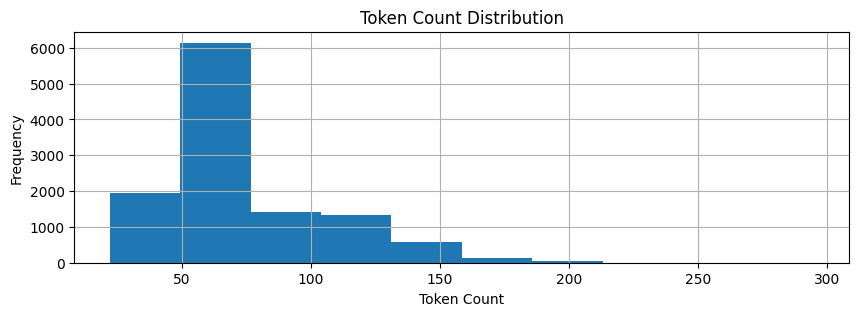

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
data['token_count'].hist()

In [42]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_community.graphs.graph_document import GraphDocument
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_openai import AzureChatOpenAI

os.environ["AZURE_OPENAI_API_KEY"] = "533894d8f28d4f238f10c0a51a46789e"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://sriks-openai.openai.azure.com/"
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-05-01-preview"
os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"] = "gpt-4o"

llm = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"],
)

llm_transformer = LLMGraphTransformer(
    llm=llm,
    node_properties=["description"],
    relationship_properties=["description"]
)     

Extract the entities, relationships from text and create graph

In [43]:
import random
random.seed(42)
data = data[data['Match_id'] == 3495290]
ids = random.sample(range(1, len(data)-1), 10)
data.head()

,Match_id,Team,Over_num,Commentary,batsman,score,token_count
9638,3495290,RCB 1st Inns,0.1,"Aaron to Kohli, SIX, Kohli wasting no time wha...",Aaron to Kohli,SIX,49
9639,3495290,RCB 1st Inns,0.2,"Aaron to Kohli, SIX, six more! Not so convinci...",Aaron to Kohli,SIX,78
9640,3495290,RCB 1st Inns,0.4,"Aaron to de Villiers, FOUR, de Villiers is off...",Aaron to de Villiers,FOUR,70
9641,3495290,RCB 1st Inns,1.0,"Aaron to de Villiers, FOUR, one bounce and ove...",Aaron to de Villiers,FOUR,68
9642,3495290,RCB 1st Inns,1.1,"Shreyas Gopal to Kohli, SIX, this is some stat...",Shreyas Gopal to Kohli,SIX,64


In [45]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

graph_documents = []
# Convert each row to a Graph Document
# this will take some time
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = [executor.submit(llm_transformer.convert_to_graph_documents, [Document(page_content=f"""You are a data processing assistant, your task is to extract entities, relationships and their labels from commentary of IPL matches. 
                                                                                     {row['Match_id'], row['Team'], row['batsman']} Commentary:{row['Commentary']} Score:{row['score']}. 
                                                                                     Extract entities not limited to bowler, batsman, fielder, score, shot_played, runs_scored, wickets_fallen, speed of the ball, spin etc.""")]) for i, row in data.iterrows()]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Converting to Graph Documents"):
        graph_documents.extend(future.result())
        

Converting to Graph Documents: 100%|██████████| 25/25 [03:19<00:00,  7.97s/it]


In [103]:
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

Generate embeddings for the extracted entities

In [106]:

from langchain_community.vectorstores import Neo4jVector
from langchain_openai import AzureOpenAIEmbeddings

# Create a vector store from the existing graph
graph_labels = graph.query("MATCH (n) RETURN DISTINCT labels(n) as labels")
labels =  set([label for row in graph_labels for label in row['labels'] if label != '__Entity__'])
# exclusion list, numbers are not good for embeddings
# you may use LLM to identify the numberic types / find a better approach
exclusion_list = ['Runs_scored', 'score', 'Score', 'Wickets_fallen', 'Wickets', 'Speed']
labels = [label for label in labels if label not in exclusion_list]
print(labels)
for labels in labels:
    vector = Neo4jVector.from_existing_graph(
        AzureOpenAIEmbeddings(),
        node_label=labels,
        text_node_properties=['id', 'description'],
        embedding_node_property='embedding'
)

['Field_position', 'Shot', 'Team_inning', 'Person', 'Ball_type', 'Shot_played', 'Match_inning', 'Fielding position', 'Nationality', 'Location', 'Area', 'Place', 'Inning', 'Delivery', 'Document', 'Team', 'Achievement', 'Event', 'Spin']


In [48]:
from graphdatascience import GraphDataScience

# Create a GraphDataScience instance
# GDS plugin must be installed in the Neo4j instance
gds = GraphDataScience(
    os.environ["NEO4J_URI"],
    auth=(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"])
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('serverLocation' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('advertisedListenAddress' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'


In [68]:
similrity_threshold = 0.95
gds.graph.drop("entities")
# exclude the score property from the graph
G, result = gds.graph.project(
    "entities", 
    "__Entity__",
    "*",
    nodeProperties=["embedding"],
    )   

# mutating the graph to add similar relationships
result = gds.knn.mutate(
    G,
    nodeProperties=["embedding"],
    mutateRelationshipType="SIMILAR",
    mutateProperty="score",
    similarityCutoff=similrity_threshold,
)
result.similarityDistribution    
print(result)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.drop($graph_name, $fail_if_missing, $db_name)'


ranIterations                                                             5
nodePairsConsidered                                                   20906
didConverge                                                            True
preProcessingMillis                                                       0
computeMillis                                                            71
mutateMillis                                                             30
postProcessingMillis                                                      0
nodesCompared                                                            78
relationshipsWritten                                                    157
similarityDistribution    {'min': 0.950531005859375, 'p5': 0.95071029663...
configuration             {'mutateProperty': 'score', 'jobId': '23ea858e...
Name: 0, dtype: object


In [73]:
# writing the graph back to the database
result = gds.knn.write(
    G,
    nodeProperties=["embedding"],
    writeRelationshipType="SIMILAR",
    writeProperty="score",
    similarityCutoff=similrity_threshold,
)
print(f"Number of relationships created: {result.relationshipsWritten}")
print(result)

Number of relationships created: 157
ranIterations                                                             4
didConverge                                                            True
nodePairsConsidered                                                   19663
preProcessingMillis                                                       0
computeMillis                                                            64
writeMillis                                                              14
postProcessingMillis                                                      0
nodesCompared                                                            78
relationshipsWritten                                                    157
similarityDistribution    {'min': 0.950531005859375, 'p5': 0.95071029663...
configuration             {'writeProperty': 'score', 'writeRelationshipT...
Name: 0, dtype: object


In [86]:
# get nodes with relationtype as SIMILAR
query = """
MATCH (n:__Entity__)-[r:SIMILAR]-(m:__Entity__)
RETURN n.id as node1, m.id as node2, r.score as score
"""
result = gds.run_cypher(query)
result.tail(20)

,node1,node2,score
1860,0,1,0.981114
1861,4,1,0.976142
1862,0,1,0.981114
1863,1 Run,1,0.957599
1864,4(3),1,0.962356
1865,28(13),1,0.953783
1866,6,1,0.975913
1867,8,1,0.972954
1868,Four,1,0.955086
1869,Rr,1,0.957091


Find similar entities by Levenshtein distance

In [76]:
import Levenshtein

edit_distance_threshold = 3
query = """
MATCH (n:__Entity__)
RETURN n.id as id, n.wcc as wcc
"""
entities_df = pd.DataFrame.from_records(graph.query(query))
print(f"Number of entities: {entities_df.shape[0]}")
print(Levenshtein.distance('Boult', 'Rohit'))
edit_distances = pd.crosstab(entities_df['id'], entities_df['id'])
# fill values with edit distance between column and row names
for i in edit_distances.columns:
    for j in edit_distances.index:
        if len(i) > 4 and len(j) > 4:
            # if i or j has "innings" in it, skip
            if "Inns" in i:
                continue
            edit_distances.loc[j, i] = Levenshtein.distance(i, j)
# find edit distances below threshold and greater than 0
edit_distances = edit_distances[(edit_distances < edit_distance_threshold)]
# create a dictionary of similar entities
edit_distances = edit_distances[edit_distances > 1].stack().to_dict()
edit_distances
# Conclusion: Probably, not a good idea to merge by names

Number of entities: 78
3


{('136.4Kph', '152.4Kph'): 2.0, ('152.4Kph', '136.4Kph'): 2.0}

## Identify Graph communities and enhance the knowledge using LLM

In [77]:
# Project the graph to create a community graph
gds.graph.drop("communities")
G, result = gds.graph.project(
    "communities",  #  Graph name
    "__Entity__",  #  Node projection
    {
        "_ALL_": {
            "type": "*",
            "orientation": "UNDIRECTED",
            "properties": {"weight": {"property": "*", "aggregation": "COUNT"}},
        }
    },
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.drop($graph_name, $fail_if_missing, $db_name)'


In [78]:
gds.wcc.mutate(G, mutateProperty="componentId")

mutateMillis                                                             2
nodePropertiesWritten                                                   78
componentCount                                                           2
componentDistribution    {'min': 1, 'p5': 1, 'max': 77, 'p999': 77, 'p9...
postProcessingMillis                                                     8
preProcessingMillis                                                      0
computeMillis                                                           15
configuration            {'mutateProperty': 'componentId', 'jobId': '92...
Name: 0, dtype: object

In [79]:
query = """
    CALL gds.graph.nodeProperties.stream('communities', 'componentId')
    YIELD nodeId, propertyValue
    WITH gds.util.asNode(nodeId).id AS node, propertyValue AS componentId
    WITH componentId, collect(node) as subgroups
    WITH componentId, subgroups, size(subgroups) AS componentSize
    RETURN componentId, componentSize, subgroups
    ORDER BY componentSize DESC
"""
components = gds.run_cypher(query)
components

,componentId,componentSize,subgroups
0,0,77,"[Negi, Samson, Hook, 4, 4(3), Short Of A Lengt..."
1,25,1,[Crouched]


In [80]:
largest_component = components["componentId"][0]
print(f"The largest component has the id {largest_component} with {components['componentSize'][0]} subgroups.")

The largest component has the id 0 with 77 subgroups.


In [81]:
largest_component_graph, _ = gds.beta.graph.project.subgraph(
    "largest_connected_components", G, f"n.componentId={largest_component}", "*"
)
largest_component_graph

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.beta.graph.project.subgraph' has been replaced by 'gds.graph.filter')} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.beta.graph.project.subgraph($graph_name, $from_graph_name, $node_filter, $relationship_filter, $config)'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.list' is deprecated.)} {position: line: 1, column: 106, offset: 105} for query: 'CALL gds.graph.list($graph_name) YIELD graphName, nodeCount, relatio

Graph({'graphName': 'largest_connected_components', 'nodeCount': 77, 'relationshipCount': 356, 'database': 'neo4j', 'configuration': {'relationshipProperties': {}, 'jobId': '49c14fd3-4ff9-41b9-a43c-000131277302', 'validateRelationships': False, 'nodeFilter': 'n.componentId=0', 'sudo': False, 'relationshipProjection': {'_ALL_': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'weight': {'aggregation': 'COUNT', 'property': '*', 'defaultValue': None}}, 'type': '*'}}, 'readConcurrency': 4, 'nodeProperties': {}, 'nodeProjection': {'__Entity__': {'label': '__Entity__', 'properties': {}}}, 'logProgress': True, 'concurrency': 4, 'creationTime': neo4j.time.DateTime(2024, 7, 15, 13, 44, 39, 58932500, tzinfo=<UTC>), 'relationshipFilter': '*', 'parameters': {}}, 'schema': {'graphProperties': {}, 'nodes': {'__Entity__': {'componentId': 'Integer (DefaultValue(-9223372036854775808), TRANSIENT)'}}, 'relationships': {'_ALL_': {'weight': 'Float (DefaultValue(

In [82]:
gds.louvain.mutate(largest_component_graph, mutateProperty="louvainCommunityId")

mutateMillis                                                             0
nodePropertiesWritten                                                   77
modularity                                                        0.470395
modularities             [0.39546774397172074, 0.4629465976518117, 0.47...
ranLevels                                                                3
communityCount                                                           8
communityDistribution    {'min': 2, 'p5': 2, 'max': 15, 'p999': 15, 'p9...
postProcessingMillis                                                    10
preProcessingMillis                                                      0
computeMillis                                                          747
configuration            {'mutateProperty': 'louvainCommunityId', 'jobI...
Name: 0, dtype: object

In [83]:
gds.graph.nodeProperties.write(largest_component_graph, ["louvainCommunityId"])

writeMillis                                    10
graphName            largest_connected_components
nodeProperties               [louvainCommunityId]
propertiesWritten                              77
Name: 0, dtype: object

In [84]:
query = """
    CALL gds.graph.nodeProperties.stream('largest_connected_components', 'louvainCommunityId')
    YIELD nodeId, propertyValue
    WITH gds.util.asNode(nodeId).id AS node, propertyValue AS communityId
    WITH communityId, collect(node) AS subgroups
    WITH communityId, subgroups, size(subgroups) AS communitySize
    RETURN communityId, communitySize, subgroups
    ORDER BY communitySize DESC
"""

communities = gds.run_cypher(query)
communities

,communityId,communitySize,subgroups
0,1,15,"[Negi, Samson, Hook, Short Of A Length Deliver..."
1,2,11,"[4, 4(3), 28(13), Four, Rr, 10(4) [4S-2], 0, 6..."
2,56,11,"[Rr 1St Inns, Cover-Point, 1 Run, South Africa..."
3,34,10,"[Heaves, Pull, Long-On Fielder, Deep Mid-Wicke..."
4,50,10,"[Off-Side, Shreyas Gopal, Flighted Delivery, M..."
5,60,9,"[Pick-Up Shot, Rcb Fans, Rcb, Hit, Riyan Parag..."
6,17,9,"[Navdeep Saini, 152.4Kph, Skiddy, Pacy, Back O..."
7,25,2,"[Touch Fuller, Ball]"
